In [2]:
%reset

In [3]:
from sklearn.datasets import fetch_openml
import numpy as np
import time
import torch
from scipy.optimize import linprog
from qpsolvers import solve_qp
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Function
import torch.nn as nn
from sklearn.model_selection import train_test_split
import sys
import StochasticGhost
import importlib
from torch.nn.utils import clip_grad_norm_
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [4]:
raw_data = pd.read_csv("compas-scores-two-years.csv")

In [5]:
df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]

In [6]:
df['length_of_stay'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['length_of_stay'] = df['length_of_stay'].dt.total_seconds() / 3600

In [7]:
null_counts = df.isnull().sum()
print(null_counts)

age                        0
c_charge_degree            0
race                       0
age_cat                    0
score_text                 0
sex                        0
priors_count               0
days_b_screening_arrest    0
decile_score               0
is_recid                   0
two_year_recid             0
c_jail_in                  0
c_jail_out                 0
length_of_stay             0
dtype: int64


In [8]:
# Calculate length_of_stay and correlation
correlation = df['length_of_stay'].corr(df['decile_score'])
print(f"Correlation between length_of_stay and decile_score: {correlation}")

Correlation between length_of_stay and decile_score: 0.20741201943031573


In [9]:
race_distribution = df['race'].value_counts(normalize=True) * 100
print(race_distribution)

# Summary of score_text
print(df['score_text'].describe())

# Cross-tabulation of sex and race
sex_race_cross_tab = pd.crosstab(df['sex'], df['race'])
print(sex_race_cross_tab)

# Summary of sex
print(df['sex'].describe())

# Percentage of two_year_recid == 1
recid_percentage = len(df[df['two_year_recid'] == 1]) / len(df) * 100
print(f"Percentage of two_year_recid == 1: {recid_percentage:.2f}%")

African-American    51.441996
Caucasian           34.073234
Hispanic             8.246922
Other                5.557356
Asian                0.502268
Native American      0.178224
Name: race, dtype: float64
count     6172
unique       3
top        Low
freq      3421
Name: score_text, dtype: object
race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285
count     6172
unique       2
top       Male
freq      4997
Name: sex, dtype: object
Percentage of two_year_recid == 1: 45.51%


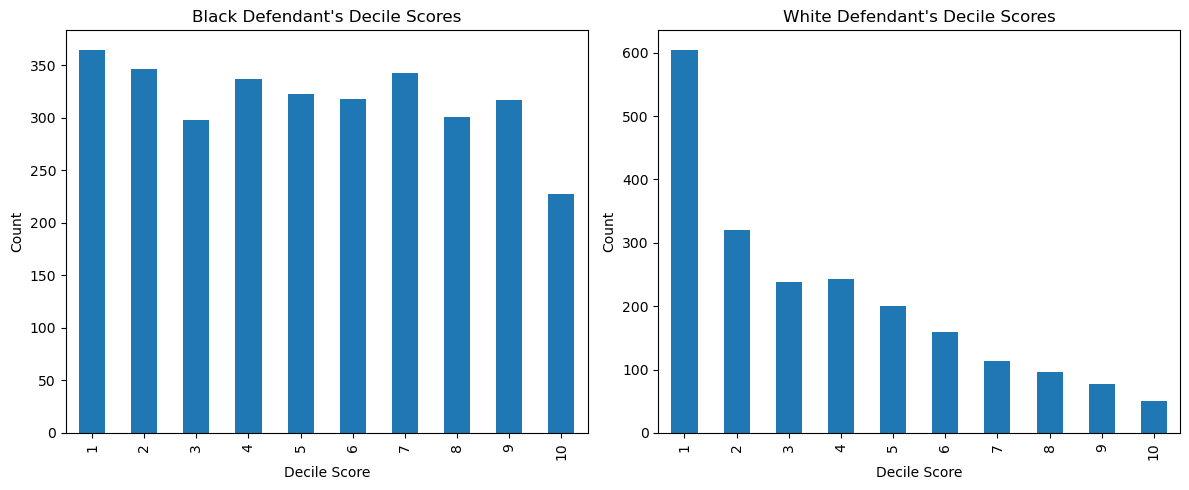

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for African-American
pblack = df[df['race'] == "African-American"]['decile_score'].value_counts(
).sort_index().plot(kind='bar', ax=axes[0])
pblack.set_title("Black Defendant's Decile Scores")
pblack.set_xlabel('Decile Score')
pblack.set_ylabel('Count')

# Plot for Caucasian
pwhite = df[df['race'] == "Caucasian"]['decile_score'].value_counts(
).sort_index().plot(kind='bar', ax=axes[1])
pwhite.set_title("White Defendant's Decile Scores")
pwhite.set_xlabel('Decile Score')
pwhite.set_ylabel('Count')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

In [11]:
df_needed = df[(df['race'] == 'Caucasian') | (df['race'] =='African-American')]

In [12]:
# Categorizing
df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
df_needed['race_code'] = pd.Categorical(df_needed['race']).codes
df_needed['gender_code'] = pd.Categorical(df_needed['sex']).codes
df_needed['score_code'] = pd.Categorical(df_needed['score_text']).codes
df_needed['charge_degree_code'] = pd.Categorical(
    df_needed['c_charge_degree']).codes

# Releveling factors
# df['age_factor'] = df['age_factor'].cat.reorder_categories(['Greater than 45', '25 - 45', 'Less than 25'], ordered=True)
# df['race_factor'] = df['race_factor'].cat.reorder_categories(['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other'], ordered=True)
# df['gender_factor'] = df['gender_factor'].cat.reorder_categories(['Female', 'Male'], ordered=True)

/tmp/ipykernel_45499/266898286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
/tmp/ipykernel_45499/266898286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
/tmp/ipykernel_45499/266898286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [13]:
in_df = df_needed[['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code']]
out_df = df_needed[['two_year_recid']]

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(torch.tensor(in_df.values), torch.tensor(out_df.values), test_size=0.2, random_state=42)

In [15]:
class SimpleClassifier(nn.Module):
    def __init__(self, layer_sizes):
        super(SimpleClassifier, self).__init__()

        # Create a list of linear layers based on layer_sizes
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu((layer(x)))
        x = torch.sigmoid(self.layers[-1](x))
        return x

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_val)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/tmp/ipykernel_45499/1797719004.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
/tmp/ipykernel_45499/1797719004.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(Y_val, dtype=torch.float32)


In [19]:
# Instantiate the model
input_size = X_train.shape[1]
hidden_size1 = 12
hidden_size2 = 8
op_size = 1
layer_sizes = [input_size, hidden_size1, hidden_size2, op_size]
model = SimpleClassifier(layer_sizes)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500

In [20]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/500, Loss: 0.6845712065696716
Epoch 2/500, Loss: 0.6493380069732666
Epoch 3/500, Loss: 0.6666020750999451
Epoch 4/500, Loss: 0.6725193858146667
Epoch 5/500, Loss: 0.5915878415107727
Epoch 6/500, Loss: 0.5603991150856018
Epoch 7/500, Loss: 0.5807744264602661
Epoch 8/500, Loss: 0.7138601541519165
Epoch 9/500, Loss: 0.5847285389900208
Epoch 10/500, Loss: 0.5785630345344543
Epoch 11/500, Loss: 0.5693435072898865
Epoch 12/500, Loss: 0.68707674741745
Epoch 13/500, Loss: 0.48973575234413147
Epoch 14/500, Loss: 0.5607801079750061
Epoch 15/500, Loss: 0.588529109954834
Epoch 16/500, Loss: 0.6250631213188171
Epoch 17/500, Loss: 0.5298442840576172
Epoch 18/500, Loss: 0.5686562657356262
Epoch 19/500, Loss: 0.595166802406311
Epoch 20/500, Loss: 0.5744359493255615
Epoch 21/500, Loss: 0.5858511924743652
Epoch 22/500, Loss: 0.6581317782402039
Epoch 23/500, Loss: 0.5996608734130859
Epoch 24/500, Loss: 0.6100982427597046
Epoch 25/500, Loss: 0.5523342490196228
Epoch 26/500, Loss: 0.591797351837158

In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pred = []
    lab = []
    x_val = []
    out = []
    x_scaled = []
    start = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs >= 0.5).float()
        total += labels.size(0)
        end = start + len(labels)
        x_val.append(X_val[start:end, :])
        x_scaled.append(inputs)
        pred.append(predictions.flatten())
        lab.append(labels.flatten())
        out.append(outputs.flatten().float())
        correct += (predictions == labels.view(-1, 1)).sum().item()
        start = end
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 66.67%


In [22]:
pred = torch.cat(pred, dim=0)
lab = torch.cat(lab, dim=0)
out = torch.cat(out, dim=0)
tensor_list = []
for i in range(len(x_val)):
    for ip_ten in (x_val[i]):
      tensor_list.append(np.array(ip_ten))
tensor_list = np.array(tensor_list)
pred = np.array(pred)
lab = np.array(lab)
out = np.array(out)

In [23]:
tensor_list_scaled = []
for i in range(len(x_scaled)):
    for ip_ten in (x_scaled[i]):
      tensor_list_scaled.append(np.array(ip_ten))
tensor_list_scaled = np.array(tensor_list_scaled)

In [24]:
df_out_scaled = pd.DataFrame(tensor_list_scaled, columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code'])
df_out_scaled["raw_out"] = (out)
df_out_scaled["true_labels"] = (lab).astype(int)

In [25]:
df_out = pd.DataFrame(tensor_list, columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code'])
df_out["pred_labels"] = (pred).astype(int)
df_out["true_labels"] = (lab).astype(int)

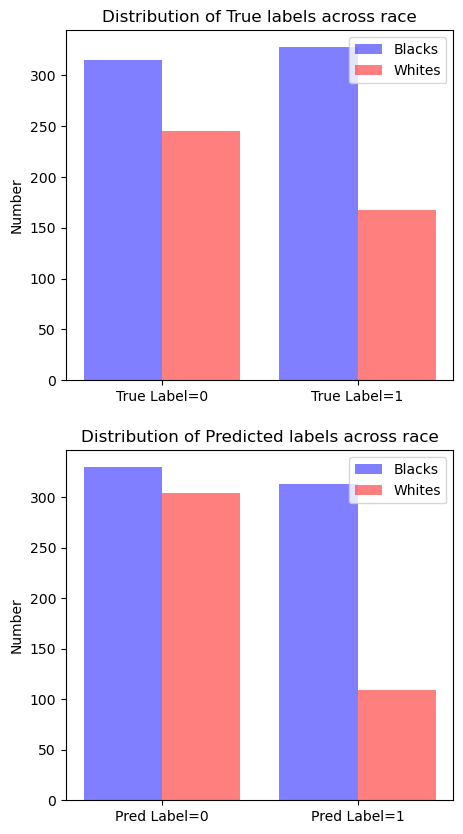

In [32]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['True Label=0', 'True Label=1']
values1 = [len(df_out[(df_out["race_code"]==0) & (df_out["true_labels"]==0)]), len(df_out[(df_out["race_code"]==0) & (df_out["true_labels"]==1)])]
values2 = [len(df_out[(df_out["race_code"]==1) & (df_out["true_labels"]==0)]), len(df_out[(df_out["race_code"]==1) & (df_out["true_labels"]==1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
        label='s=black', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
        width=bar_width, label='s=white', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)
# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
ax[0].set_title('Distribution of True labels across race')
ax[0].legend()


categories2 = ['Pred Label=0', 'Pred Label=1']
values3 = [len(df_out[(df_out["race_code"]==0) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["race_code"]==0) & (df_out["pred_labels"]==1)])]
values4 = [len(df_out[(df_out["race_code"]==1) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["race_code"]==1) & (df_out["pred_labels"]==1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
        label='s=black', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
        width=bar_width, label='s=white', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
ax[1].set_title('Distribution of Predicted labels across race')
ax[1].legend()


In [30]:
tp_black = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 0)])
fp_black = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 0)])
tn_black = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 0)])
fn_black = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 0)])

tp_white = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 1)])
fp_white = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 1)])
tn_white = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 1)])
fn_white = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 1)])

In [31]:
fpr_black = fp_black/(fp_black + tn_black)
tpr_black = tp_black/(tp_black + fn_black)
fpr_white = fp_white/(fp_white + tn_white)
tpr_white = tp_white/(tp_white + fn_white)

print("FPR black", fpr_black)
print("TPR black", tpr_black)
print("FPR white", fpr_white)
print("TPR white", tpr_white)

FPR black 0.31746031746031744
TPR black 0.649390243902439
FPR white 0.15918367346938775
TPR white 0.4166666666666667


In [137]:
#values3 = [len(df_out[(df_out["race_code"]==0) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["race_code"]==0) & (df_out["pred_labels"]==1)])]
#values4 = [len(df_out[(df_out["race_code"]==1) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["race_code"]==1) & (df_out["pred_labels"]==1)])]
# values1 = [len(df_out[df_out["race_code"]==0 & df_out["true_labels"]==0]), len(df_out[df_out["race_code"]==0 & df_out["true_labels"]==1])]
# values2 = [len(df_out[df_out["race_code"]==1 & df_out["true_labels"]==0]), len(df_out[df_out["race_code"]==1 & df_out["true_labels"]==1])]

values1 = [len(df_out[(df_out["race_code"]==0) & (df_out["true_labels"]==0)]), len(df_out[(df_out["race_code"]==0) & (df_out["true_labels"]==1)])]
values2 = [len(df_out[(df_out["race_code"]==1) & (df_out["true_labels"]==0)]), len(df_out[(df_out["race_code"]==1) & (df_out["true_labels"]==1)])]


In [138]:
tp_white_condition = (pred == 1) & (lab == 1) & (tensor_list[:, 5] == 1)
tp_white = np.count_nonzero(tp_white_condition)
print(tp_white)

66


In [24]:
tp_black_condition = (pred == 1) & (lab == 1) & (tensor_list[:, 5] == 0)
tp_black = np.count_nonzero(tp_black_condition)
print(tp_black)

222


In [139]:
fp_white_condition = (pred == 1) & (lab == 0) & (tensor_list[:, 5] == 1)
fp_white = np.count_nonzero(fp_white_condition)
print("False positives in white:", fp_white)
p_white_condition = (lab == 1) & (tensor_list[:, 5] == 1)
p_white = np.count_nonzero(p_white_condition)
print("Total positives in white:", p_white)
print("False positive rate in white:", fp_white/p_white)

False positives in white: 42
Total positives in white: 157
False positive rate in white: 0.267515923566879


In [140]:
fp_black_condition = (pred == 1) & (lab == 0) & (tensor_list[:, 5] == 0)
fp_black = np.count_nonzero(fp_black_condition)
print("False positives in black:", fp_black)
p_black_condition = (lab == 1) & (tensor_list[:, 5] == 1)
p_black = np.count_nonzero(p_black_condition)
print("Total positives in black:", p_black)
print("False positive rate in black:", fp_black/p_black)

False positives in black: 99
Total positives in black: 157
False positive rate in black: 0.6305732484076433


<BarContainer object of 2 artists>

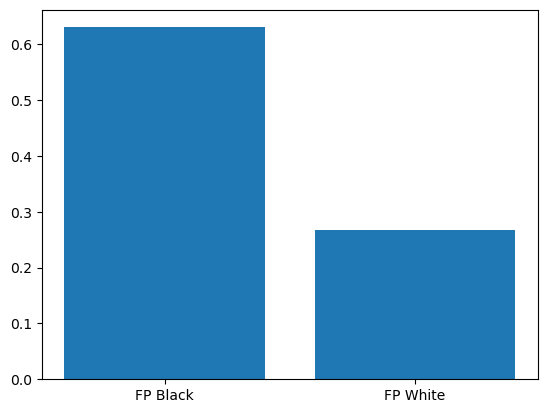

In [141]:
plt.bar(['FP Black', 'FP White'], [fp_black/p_black, fp_white/p_white])

In [142]:
out_black_0_label = out[(tensor_list[:, 5] == 0) & (lab == 0)]
out_white_0_label = out[(tensor_list[:, 5] == 1) & (lab == 0)]
#print(lab.shape)
# The mean value of the predicted label for black when the true value is 0 (Shows Blacks have a higher false positivity tendency)
avg_b_l_0 = np.sum(out_black_0_label)/len(out_black_0_label)
print(avg_b_l_0)
# The mean value of the predicted label for white when the true value is 0 (Shows Whites have a lower false positivity tendency)
avg_w_l_0 = np.sum(out_white_0_label)/len(out_white_0_label)
print(avg_w_l_0)

0.4159466406542384
0.32659554270516455


In [143]:
prob_out_black_0_label = out_black_0_label/np.sum(out_black_0_label)
prob_out_white_0_label = out_white_0_label/np.sum(out_black_0_label)

/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

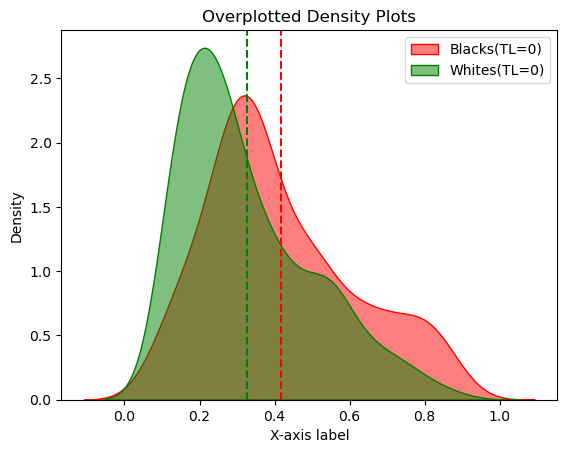

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data for the density plots
# data1 = np.random.randn(1000)  # Example data for the first distribution
# data2 = np.random.randn(800)   # Example data for the second distribution

# Create density plots with alpha blending
sns.kdeplot(out_black_0_label, label='Blacks(TL=0)',
            fill=True, color='red', alpha=0.5)
sns.kdeplot(out_white_0_label, label='Whites(TL=0)',
            fill=True, color='green', alpha=0.5)

#plt.ylim(0, 1)

# Add labels and a legend
plt.xlabel('X-axis label')
plt.ylabel('Density')
plt.title('Overplotted Density Plots')
plt.axvline(x=avg_b_l_0, color='red', linestyle='--')
plt.axvline(x=avg_w_l_0, color='green', linestyle='--')
plt.legend()

# Show the plot
plt.show()

In [45]:
sum = 0
for i in range(min(len(out_black_0_label), len(out_white_0_label))):
    sum = sum + out_white_0_label[i]*(np.log(out_white_0_label[i]/out_black_0_label[i]))

In [46]:
print(sum)

2.69569369207602


In [55]:
out_black_1_label = out[(tensor_list[:, 5] == 0) & (lab == 1)]
out_white_1_label = out[(tensor_list[:, 5] == 1) & (lab == 1)]
# The mean value of the predicted label for black when the true value is 1 (Shows Blacks have a lower false negative tendency)
avg_b_l_1 = np.sum(out_black_1_label)/len(out_black_1_label)
print(avg_b_l_1)
# The mean value of the predicted label for black when the true value is 1 (Shows Whites have a higher false negative tendency)
avg_w_l_1 = np.sum(out_white_1_label)/len(out_white_1_label)
print(avg_w_l_1)

0.5822157958264196
0.42962976929488456


Text(0, 0.5, 'Marginal avg ')

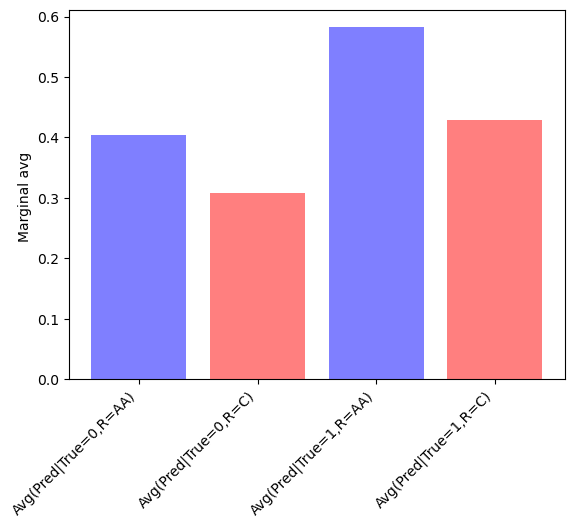

In [56]:
colors = ['blue', 'red', 'blue', 'red']
plt.bar(['Avg(Pred|True=0,R=AA)', 'Avg(Pred|True=0,R=C)', 'Avg(Pred|True=1,R=AA)',
        'Avg(Pred|True=1,R=C)'], [avg_b_l_0, avg_w_l_0, avg_b_l_1, avg_w_l_1], color=colors, alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Marginal avg ')

Text(0, 0.5, 'Marginal avg ')

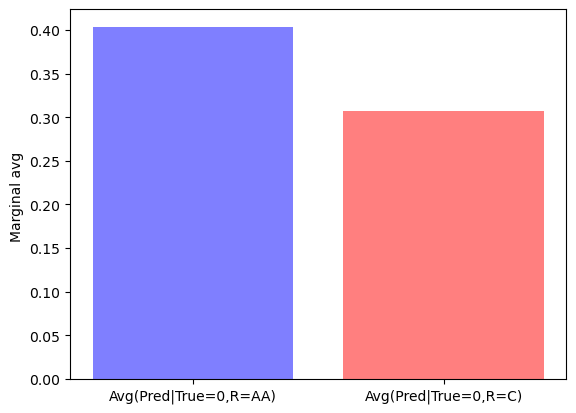

In [57]:
colors = ['blue', 'red']
plt.bar(['Avg(Pred|True=0,R=AA)', 'Avg(Pred|True=0,R=C)'], [avg_b_l_0, avg_w_l_0], color=colors, alpha=0.5)
#plt.xticks(rotation=45, ha='right')
plt.ylabel('Marginal avg ')

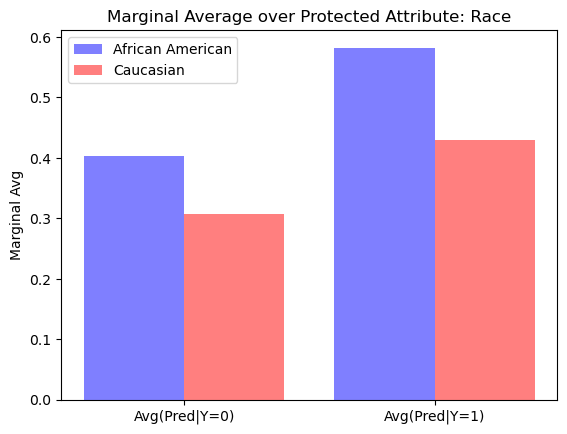

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Avg(Pred|Y=0)', 'Avg(Pred|Y=1)']
values1 = [avg_b_l_0, avg_b_l_1]
values2 = [avg_w_l_0, avg_w_l_1]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories))

# Plot the first group of bars (Bars 1 and 2)
plt.bar(index, values1, color='blue', width=bar_width, label='African American', alpha = 0.5)

# Plot the second group of bars (Bars 3 and 4)
plt.bar(index + bar_width, values2, color='red',width=bar_width, label='Caucasian', alpha=0.5)

# Adjust the x-axis ticks and labels
plt.xticks(index + bar_width / 2, categories)

# Add labels and legend
#plt.xlabel('Categories')
plt.ylabel('Marginal Avg')
plt.title('Marginal Average over Protected Attribute: Race')
plt.legend()

# Show the plot
plt.show()

In [59]:
blacks_0 = len(df_needed[(df_needed['race_code'] == 0)
                         & (df_needed['two_year_recid'] == 0)])
whites_0 = len(df_needed[(df_needed['race_code'] == 1)
                         & (df_needed['two_year_recid'] == 0)])
blacks_1 = len(df_needed[(df_needed['race_code'] == 0)
                         & (df_needed['two_year_recid'] == 1)])
whites_1 = len(df_needed[(df_needed['race_code'] == 1)
                         & (df_needed['two_year_recid'] == 1)])
print("True label = 0 =>", "Blacks:", blacks_0, " Whites:", whites_0)
print("True label = 1 =>", "Blacks:", blacks_1, " Whites:",whites_1)

True label = 0 => Blacks: 1514  Whites: 1281
True label = 1 => Blacks: 1661  Whites: 822


In [61]:
print(type(tensor_list))

<class 'numpy.ndarray'>


In [76]:
df_out.head(5)

,priors_count,score_code,age_code,gender_code,race_code,crime_code,charge_degree_code,pred_labels,true_labels
0,1,1,1,0,1,0,0,0.0,1.0
1,2,1,0,1,0,1,1,0.0,0.0
2,0,2,2,0,0,0,0,0.0,0.0
3,1,1,0,1,1,0,0,0.0,1.0
4,0,1,0,1,0,0,0,0.0,1.0


In [47]:
import math
import torch
import torch.linalg as linalg


def calculate_2_wasserstein_dist(X, Y):
    '''
    Calulates the two components of the 2-Wasserstein metric:
    The general formula is given by: d(P_X, P_Y) = min_{X, Y} E[|X-Y|^2]
    For multivariate gaussian distributed inputs z_X ~ MN(mu_X, cov_X) and z_Y ~ MN(mu_Y, cov_Y),
    this reduces to: d = |mu_X - mu_Y|^2 - Tr(cov_X + cov_Y - 2(cov_X * cov_Y)^(1/2))
    Fast method implemented according to following paper: https://arxiv.org/pdf/2009.14075.pdf
    Input shape: [b, n] (e.g. batch_size x num_features)
    Output shape: scalar
    '''

    if X.shape != Y.shape:
        raise ValueError("Expecting equal shapes for X and Y!")

    # the linear algebra ops will need some extra precision -> convert to double
    X, Y = X.transpose(0, 1).double(), Y.transpose(0, 1).double()  # [n, b]
    mu_X, mu_Y = torch.mean(X, dim=1, keepdim=True), torch.mean(
        Y, dim=1, keepdim=True)  # [n, 1]
    n, b = X.shape
    fact = 1.0 if b < 2 else 1.0 / (b - 1)

    # Cov. Matrix
    E_X = X - mu_X
    E_Y = Y - mu_Y
    cov_X = torch.matmul(E_X, E_X.t()) * fact  # [n, n]
    cov_Y = torch.matmul(E_Y, E_Y.t()) * fact

    # calculate Tr((cov_X * cov_Y)^(1/2)). with the method proposed in https://arxiv.org/pdf/2009.14075.pdf
    # The eigenvalues for M are real-valued.
    C_X = E_X * math.sqrt(fact)  # [n, n], "root" of covariance
    C_Y = E_Y * math.sqrt(fact)
    M_l = torch.matmul(C_X.t(), C_Y)
    M_r = torch.matmul(C_Y.t(), C_X)
    M = torch.matmul(M_l, M_r)
    # add small constant to avoid infinite gradients from sqrt(0)
    S = linalg.eigvals(M) + 1e-15
    sq_tr_cov = S.sqrt().abs().sum()

    # plug the sqrt_trace_component into Tr(cov_X + cov_Y - 2(cov_X * cov_Y)^(1/2))
    trace_term = torch.trace(cov_X + cov_Y) - 2.0 * sq_tr_cov  # scalar

    # |mu_X - mu_Y|^2
    diff = mu_X - mu_Y  # [n, 1]
    mean_term = torch.sum(torch.mul(diff, diff))  # scalar

    # put it together
    return (trace_term + mean_term).float()

In [89]:
len = min((out_black_0_label).shape[0], (out_white_0_label).shape[0])
#print(len)
X = torch.tensor(out_black_0_label[0:len])
Y = torch.tensor(out_white_0_label[0:len])
#X = torch.unsqueeze(X, 1)
#Y = torch.unsqueeze(Y, 1)
#print(X.shape)
#calculate_2_wasserstein_dist(X, Y)

In [68]:
print(np.mean(out_black_0_label))
print(np.mean(out_white_0_label))
print(np.std(out_black_0_label))
print(np.std(out_white_0_label))

0.41249266
0.32463175
0.1993905
0.1722356


In [70]:
print(torch.mean(X.flatten()))
print(torch.mean(Y.flatten()))
print(torch.std(X.flatten()))
print(torch.std(Y.flatten()))

tensor(0.4126)
tensor(0.3246)
tensor(0.1997)
tensor(0.1726)


In [64]:
# Number of samples
num_samples = 1000

# Mean and standard deviation
mean_X = 5.0
std_X = 2.0

mean_Y = 5.0
std_Y = 2.0

# Generate samples from a Gaussian distribution with mean and std
samples_X = mean_X + std_X * torch.randn(num_samples)
samples_Y = mean_Y + std_Y * torch.randn(num_samples)

# Print the samples
X = torch.unsqueeze(samples_X, 1)
Y = torch.unsqueeze(samples_Y, 1)
#print(X.shape)
calculate_2_wasserstein_dist(X, Y)

tensor(0.0183)

In [72]:
import numpy as np
from scipy.stats import wasserstein_distance

wasserstein_dist = wasserstein_distance(out_black_0_label[0:len], out_white_0_label[0:len])
print(wasserstein_dist)

0.08967858348536281


In [80]:
import torch.nn.functional as F

In [81]:
def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    kl_div_p_m = F.kl_div(p.log(), m, reduction='batchmean')
    kl_div_q_m = F.kl_div(q.log(), m, reduction='batchmean')
    return 0.5 * (kl_div_p_m + kl_div_q_m)

In [94]:
len = min((out_black_0_label).shape[0], (out_white_0_label).shape[0])
# print(len)
X = torch.tensor(out_black_0_label[0:len])
Y = torch.tensor(out_white_0_label[0:len])
x = X/torch.sum(X)
y = Y/(Y.shape[0])
d = jensen_shannon_divergence(X, Y)

In [96]:
print(d)

tensor(0.0288)


                    priors_count  score_code  age_code  gender_code  \
priors_count            1.000000   -0.200338 -0.192129     0.124162   
score_code             -0.200338    1.000000  0.082410    -0.092920   
age_code               -0.192129    0.082410  1.000000    -0.024388   
gender_code             0.124162   -0.092920 -0.024388     1.000000   
race_code              -0.180121    0.100986  0.017360    -0.049338   
crime_code             -0.122414    0.086230 -0.053293    -0.018104   
charge_degree_code     -0.122414    0.086230 -0.053293    -0.018104   
raw_out                 0.685781   -0.235983  0.009422     0.220332   
true_labels             0.262676   -0.111096  0.015505     0.126301   

                    race_code  crime_code  charge_degree_code   raw_out  \
priors_count        -0.180121   -0.122414           -0.122414  0.685781   
score_code           0.100986    0.086230            0.086230 -0.235983   
age_code             0.017360   -0.053293           -0.053293  0

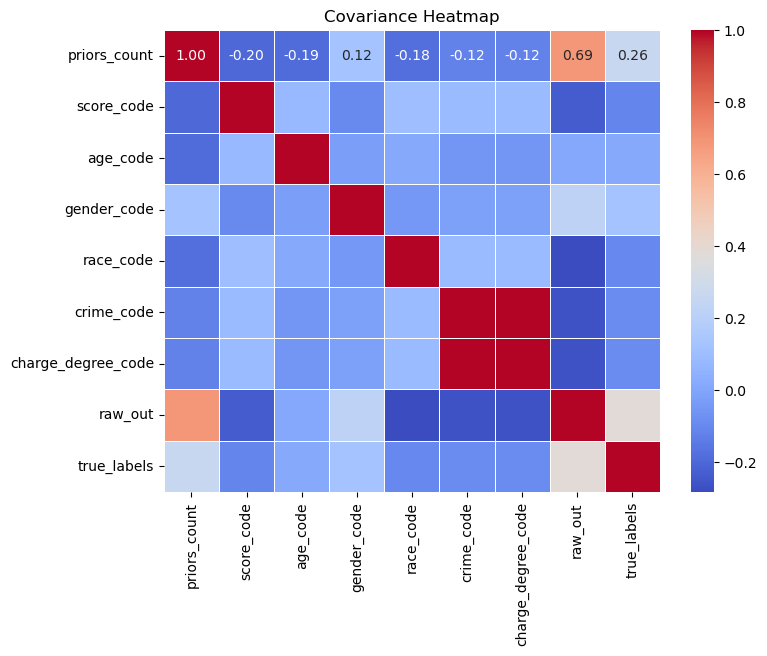

In [175]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df
# For demonstration, let's create a sample DataFrame
# Calculate covariance matrix
cov_matrix = df_out_scaled.corr()

print(df_out_scaled.corr())

# Plot the covariance heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_out_scaled.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Covariance Heatmap')
plt.show()